In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.io import savemat
import math
from loading_real_wave_noise import loading_real_wave_noise
from Reading_path_test import loading_paths_from_MAT
from Control_filter_selection import Control_filter_selection
from FxNLMS_algorithm import FxNLMS, train_fxnlms_algorithm
from Disturbance_generation import Disturbance_generation_from_real_noise
from Combine_SFANC_with_FxNLMS import SFANC_FxNLMS

print(torch.cuda.is_available())

In [3]:
# real noises
fs = 16000
StepSize = 0.002 #原来是0.0001 学习率0.002暂时不要改变
sound_name = 'NeighborSpeaking_1.1' #Connect_Aircraft_Traffic
waveform, resample_rate = loading_real_wave_noise(folde_name='Real Noise Examples/', sound_name=sound_name+'.wav')
print('yeap')

yeap


In [4]:
# Pri_path, Secon_path = loading_paths_from_MAT(folder='Pz and Sz', subfolder='Dongyuan', Pri_path_file_name='Primary_path.mat', Sec_path_file_name='Secondary_path.mat')
Pri_path, Secon_path = loading_paths_from_MAT(folder='C:\PycharmProjects\SFANC-FxNLMS-ANC-Algorithm-based-on-Deep-Learning-main', subfolder='Primary and Secondary Path',Pri_path_file_name='Primary_path.mat', Sec_path_file_name='Secondary_path.mat')
Dis, Fx, Re = Disturbance_generation_from_real_noise(fs=fs, Repet=0, wave_form=waveform, Pri_path=Pri_path, Sec_path=Secon_path)
# Dis: disturbance (cotrolled noise)， Fx: fixed-x signal, Re: repeated waveform (primary_noise) Repetition=Repet+1
print('yeap')

yeap


In [5]:
print(waveform.shape)
print(Re.shape)
print(Dis.shape)

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

torch.Size([1, 160000])
torch.Size([160000])
torch.Size([160000])


[========================================================================] 100%


[ 1.25717670e-05  7.84501026e-05  5.42883499e-05 ... -8.03159364e-03
  2.16217060e-03  5.77602489e-03]
tensor([ 1.2572e-05,  7.8418e-05,  5.6335e-05,  ..., -9.3928e-03,
         2.7584e-03,  8.6199e-03])


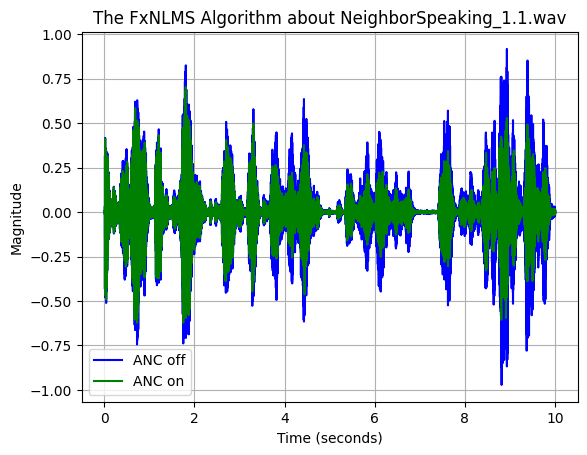

In [6]:
from sqlite3 import Time

# FxNLMS

controller = FxNLMS(Len=1024) # 1024 is the same size of coeffient vector of fixed-filter
ErrorFxNLMS = train_fxnlms_algorithm(Model=controller, Ref=Fx, Disturbance=Dis, Stepsize=StepSize)

# 假设 ErrorFxNLMS 是一个包含FxNLMS误差的列表或数组
ErrorFxNLMS = np.array(ErrorFxNLMS)  # 将 ErrorFxNLMS 转换为 numpy 数组
print(ErrorFxNLMS)
print(Dis)
# 创建与 ErrorFxNLMS 长度相同的时间序列
start_time = 0  # 开始时间
end_time = 10  # 结束时间 要修改
lenth = 160000
time_sequence = torch.linspace(start_time, end_time, steps=lenth)

plt.title('The FxNLMS Algorithm about NeighborSpeaking_1.1.wav')
plt.plot(time_sequence, Dis, color='blue', label='ANC off')
plt.plot(time_sequence, ErrorFxNLMS, color='green', label='ANC on')
plt.ylabel('Magnitude')
plt.xlabel('Time (seconds)')
plt.legend()
plt.grid()
# plt.savefig('./pdf/FxNLMS_NeighborSpeaking_1.1.wav.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

In [7]:
# Combine SFANC with FxNLMS

# prediction index
id_vector = Control_filter_selection(fs=16000, Primary_noise=Re.unsqueeze(0)) # Primary_noise: torch.Size([1, XX])
print(id_vector)

# Using prediction index in SFANC_FxNLMS
FILE_NAME_PATH = 'Trained models/Pretrained_Control_filters.mat'
SFANC_FxNLMS_Cancellation = SFANC_FxNLMS(MAT_FILE=FILE_NAME_PATH, fs=16000)
Error_SFANC_FxNLMS = SFANC_FxNLMS_Cancellation.noise_cancellation(Dis=Dis, Fx=Fx, filter_index=id_vector, Stepsize=StepSize)

plt.title('The Hybrid SFANC-FxNLMS Algorithm about NeighborSpeaking_1.1.wav')
plt.plot(time_sequence, Dis, color='blue', label='ANC off')
plt.plot(time_sequence, Error_SFANC_FxNLMS, color='red', label='ANC on')
plt.ylabel('Magnitude')
plt.xlabel('Time (seconds)')
plt.legend()
plt.grid()
# plt.savefig('./pdf/SFANC_FxNLMS_NeighborSpeaking_1.1.wav.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

The primary nosie has 10 seconds !!!
[11, 11, 7, 11, 7, 7, 7, 7, 11, 11]


TypeError: __init__() missing 1 required positional argument: 'Wc0'